In [41]:
# voor data handling
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
import math

# voor plots
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import umap # LET OP: installeren met pip install umap-learn (dus NIET: pip install umap)
sns.set_style('darkgrid')

from sklearn.mixture import GaussianMixture
import optuna
import plotly

# voor hiërarchisch clusteren
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

# voor bootstrapping
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample

# voor testen op significante verschillen
from scipy.stats import chi2_contingency, kruskal, multivariate_normal

# voor uitvoeren DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# voor uitvoeren HDBSCAN*
# installeren met: pip install hdbscan
import hdbscan

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

# voor bootstrapping
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample

# voor testen op significante verschillen
from scipy.stats import chi2_contingency, kruskal

In [42]:
df = pd.read_csv(r"C:\Users\mitch\OneDrive\Documenten\Studie-Toegepaste-wiskunde\statistiek\stat5\Eindopdracht\college_math.csv", sep = ',')
df_heel = df
useless_var = ["age", "gender",'commute_minutes','grade_final','grade_period1','grade_period2','past_failures','health_status','support_family']
df = df.drop(columns=useless_var)
num_var = [
    "school_absences",
    "weekly_study_hours"
]
bin_var = [
    "extra_paid_classes",
    "support_school",
    "internet_access"
]
ord_var = [
    "alcohol_weekday",
    "alcohol_weekend",
    "free_time",
    "social_outings"
]
df = df.copy()
boundaries = 0.3
for col in ord_var:
    df[col] = df[col] + np.random.uniform(-1 * boundaries, boundaries, size=len(df))
    
df

alcohol_weekday  alcohol_weekend  extra_paid_classes  free_time  \
0           0.993224         1.153044                   0   4.817407   
1           1.722408         2.146286                   0   2.098565   
2           3.019613         3.120414                   0   4.010168   
3           1.000713         1.294126                   1   3.268688   
4           0.939964         0.784095                   0   3.976061   
..               ...              ...                 ...        ...   
568         3.213631         4.163320                   1   1.900553   
569         1.199237         0.702427                   0   2.023381   
570         1.105674         2.820205                   0   3.285799   
571         1.254908         2.106450                   0   5.010150   
572         0.800355         1.241652                   0   2.798959   

     internet_access  school_absences  social_outings  support_school  \
0                  0                0        3.283630               0   
1                  0                0        4.277965               0   
2                  1                8        3.847325               0   
3                  1                0        2.777697               0   
4                  1               20        3.816662               0   
..               ...              ...             ...             ...   
568                1               13        5.276680               0   
569                0                0        1.052589               0   
570                1               11        2.862794               0   
571                0                0        2.975273               0   
572                0                4        4.285384               1   

     weekly_study_hours  
0                   1.5  
1                   4.2  
2                   2.1  
3                  12.4  
4                   4.7  
..                  ...  
568                 2.9  
569                 2.5  
570                 2.7  
571                 4.8  
572                 2.1  

[573 rows x 9 columns]

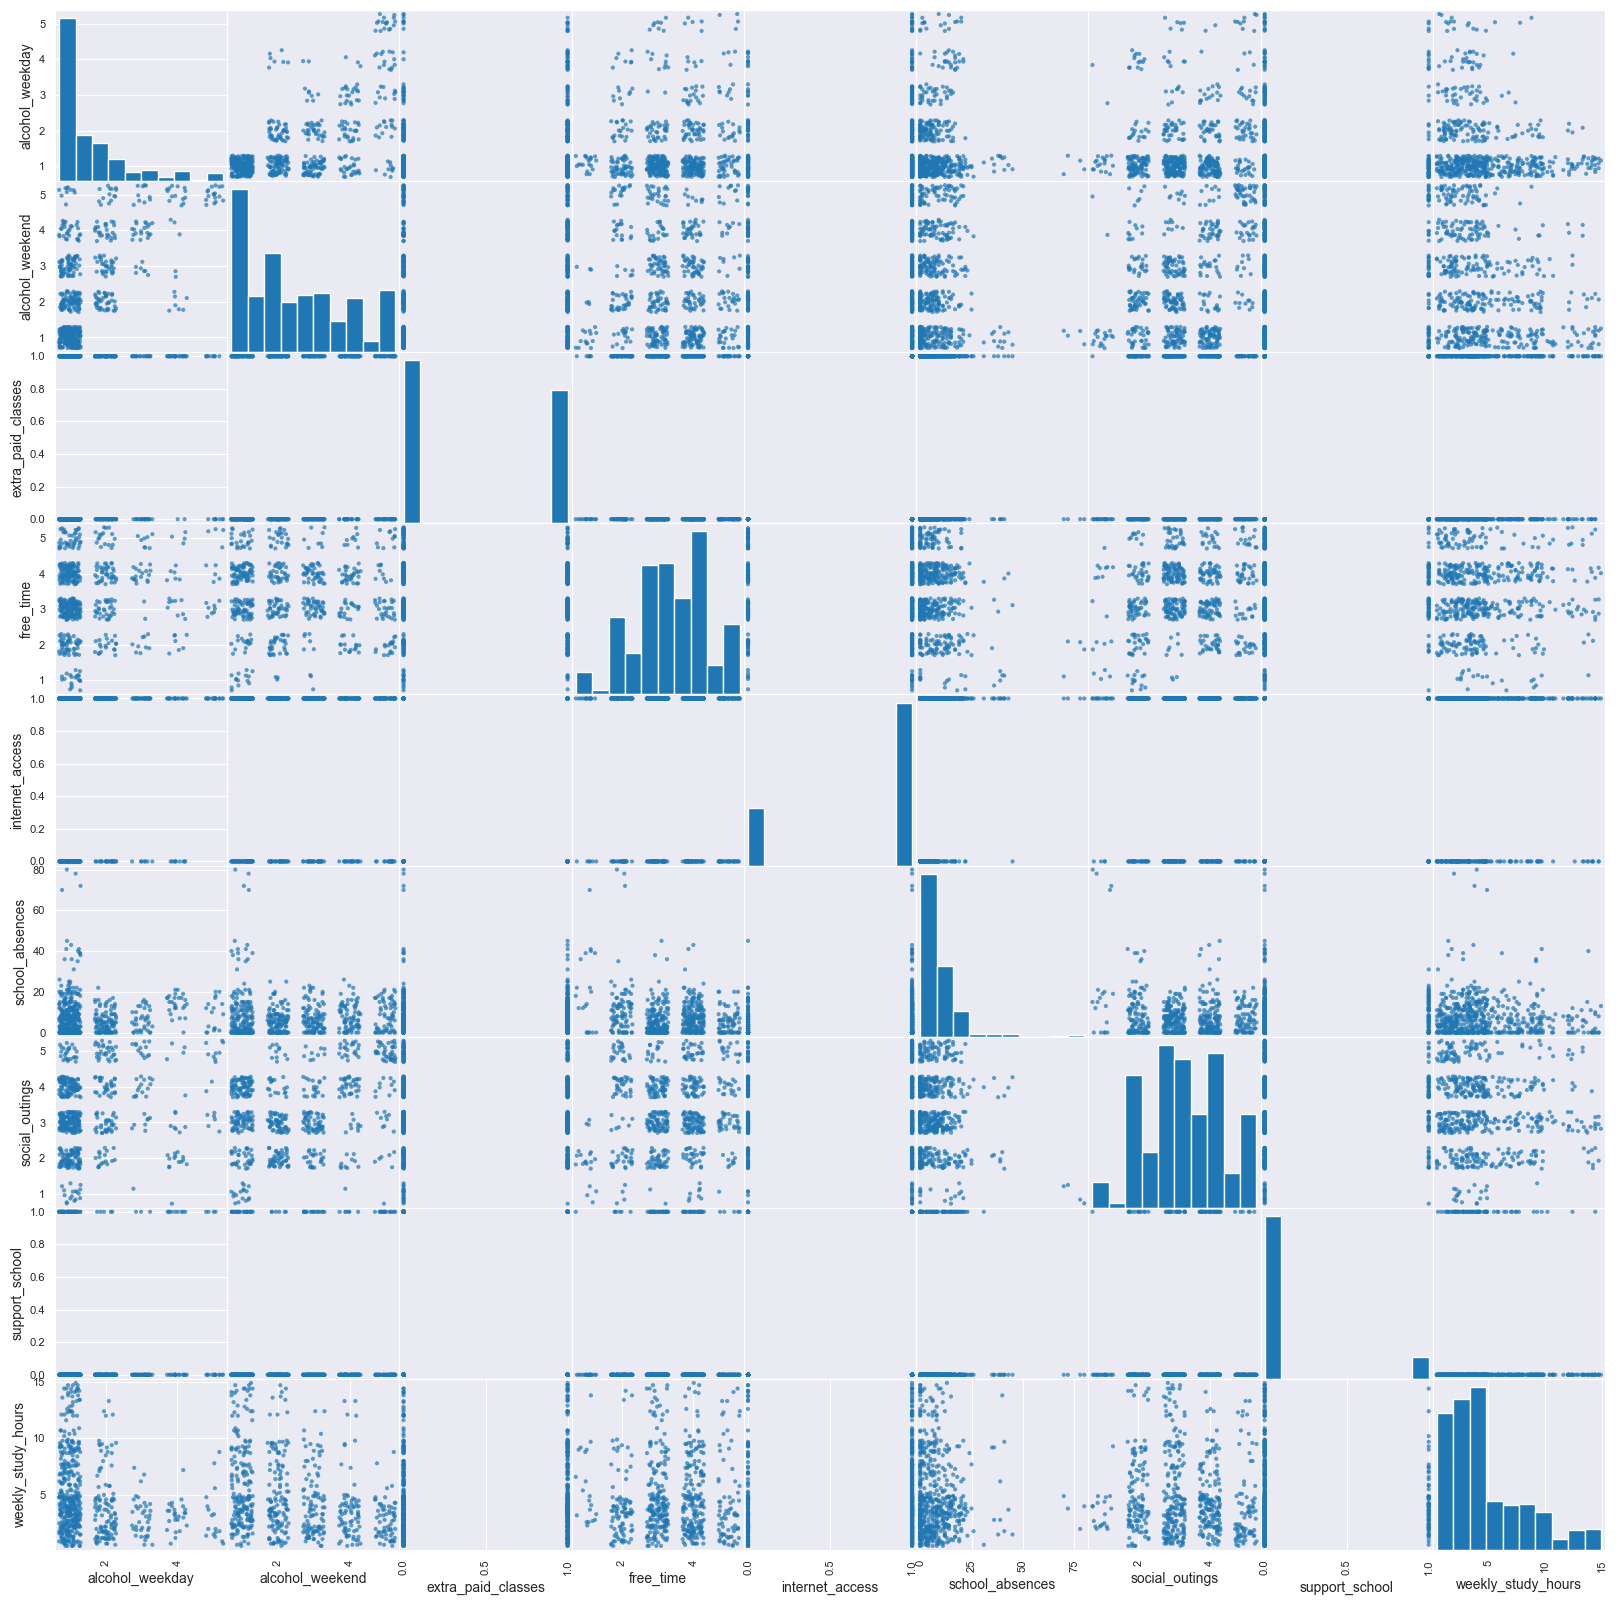

In [43]:
scatter_matrix(df, figsize=(20, 20), diagonal="hist", alpha=0.7)
plt.show()

In [44]:
df.isna().sum()

alcohol_weekday       0
alcohol_weekend       0
extra_paid_classes    0
free_time             0
internet_access       0
school_absences       0
social_outings        0
support_school        0
weekly_study_hours    0
dtype: int64

In [45]:
scaler = MinMaxScaler()
scaler.fit(df) # dit hebben we later nodig
df_scaled = scaler.fit_transform(df)

In [46]:
df1 = df
df1_scaled = df_scaled
df2 = df
df2_scaled = df_scaled
df3 = df
df3_scaled = df_scaled
df4 = df
df4_scaled = df_scaled

In [47]:
def objective(trial):
    n_components = trial.suggest_int("n_components", 1, 10)
    covariance_type = trial.suggest_categorical("covariance_type", ["full", "diag", "tied", "spherical"])
    reg_covar = trial.suggest_float("reg_covar", 1e-6, 1e-2, log=True)

    gmm_model = GaussianMixture(n_components=n_components, covariance_type=covariance_type, reg_covar=reg_covar)
    gmm_model.fit(df3_scaled)
    return gmm_model.bic(df3_scaled)

# maak Optuna-study met deze procedure aan
study = optuna.create_study(direction="minimize")

# voer Optuna grid search uit
optuna.logging.disable_default_handler() # optioneel: voorkom output per study
study.optimize(objective, n_trials=1000)

In [48]:
# bekijk optimalisatieproces
optuna.visualization.plot_optimization_history(study)

In [49]:
optuna.visualization.plot_slice(study)

In [50]:
best_params = study.best_params
best_params

{'n_components': 10,
 'covariance_type': 'diag',
 'reg_covar': 1.0025586302750911e-06}

In [51]:
def bootstrap_gmm_stability(X, scaler=None, n_bootstraps=100, gmm_params=None):
    n_components = gmm_params.get("n_components", 9)
    covariance_type = gmm_params.get("covariance_type", "diag")
    reg_covar = gmm_params.get("reg_covar", 1e-6)

    all_weights = []

    for i in range(n_bootstraps):
        X_resampled = resample(X, replace=True, random_state=i)

        if scaler is not None:
            X_resampled = scaler().fit_transform(X_resampled)

        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, reg_covar=reg_covar)

        gmm.fit(X_resampled)
        all_weights.append(gmm.weights_)

    return np.array(all_weights)

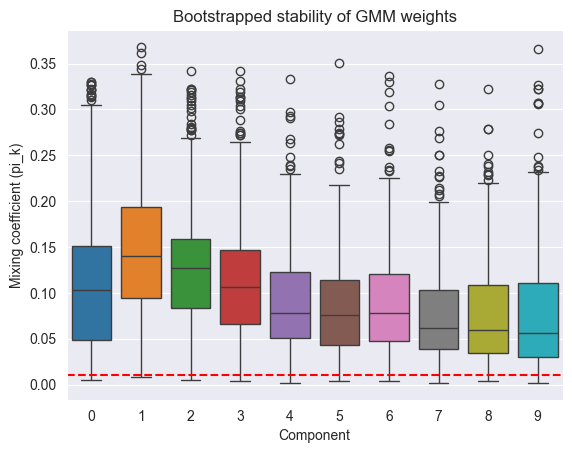

In [52]:
weights_matrix = bootstrap_gmm_stability(df3_scaled, scaler=MinMaxScaler, n_bootstraps=500, gmm_params=best_params)

# visualiseer gewichten
sns.boxplot(data=weights_matrix)
plt.xlabel("Component")
plt.ylabel("Mixing coefficient (pi_k)")
plt.title("Bootstrapped stability of GMM weights")
plt.axhline(0.01, linestyle = 'dashed', color = 'red')
plt.show()

In [53]:
best_gmm = GaussianMixture(n_components=10, covariance_type=best_params['covariance_type'], reg_covar=best_params['reg_covar'])
best_gmm.fit(df3_scaled)

GaussianMixture(covariance_type='diag', n_components=10,
                reg_covar=1.0025586302750911e-06)

In [54]:
df3

alcohol_weekday  alcohol_weekend  extra_paid_classes  free_time  \
0           0.993224         1.153044                   0   4.817407   
1           1.722408         2.146286                   0   2.098565   
2           3.019613         3.120414                   0   4.010168   
3           1.000713         1.294126                   1   3.268688   
4           0.939964         0.784095                   0   3.976061   
..               ...              ...                 ...        ...   
568         3.213631         4.163320                   1   1.900553   
569         1.199237         0.702427                   0   2.023381   
570         1.105674         2.820205                   0   3.285799   
571         1.254908         2.106450                   0   5.010150   
572         0.800355         1.241652                   0   2.798959   

     internet_access  school_absences  social_outings  support_school  \
0                  0                0        3.283630               0   
1                  0                0        4.277965               0   
2                  1                8        3.847325               0   
3                  1                0        2.777697               0   
4                  1               20        3.816662               0   
..               ...              ...             ...             ...   
568                1               13        5.276680               0   
569                0                0        1.052589               0   
570                1               11        2.862794               0   
571                0                0        2.975273               0   
572                0                4        4.285384               1   

     weekly_study_hours  
0                   1.5  
1                   4.2  
2                   2.1  
3                  12.4  
4                   4.7  
..                  ...  
568                 2.9  
569                 2.5  
570                 2.7  
571                 4.8  
572                 2.1  

[573 rows x 9 columns]

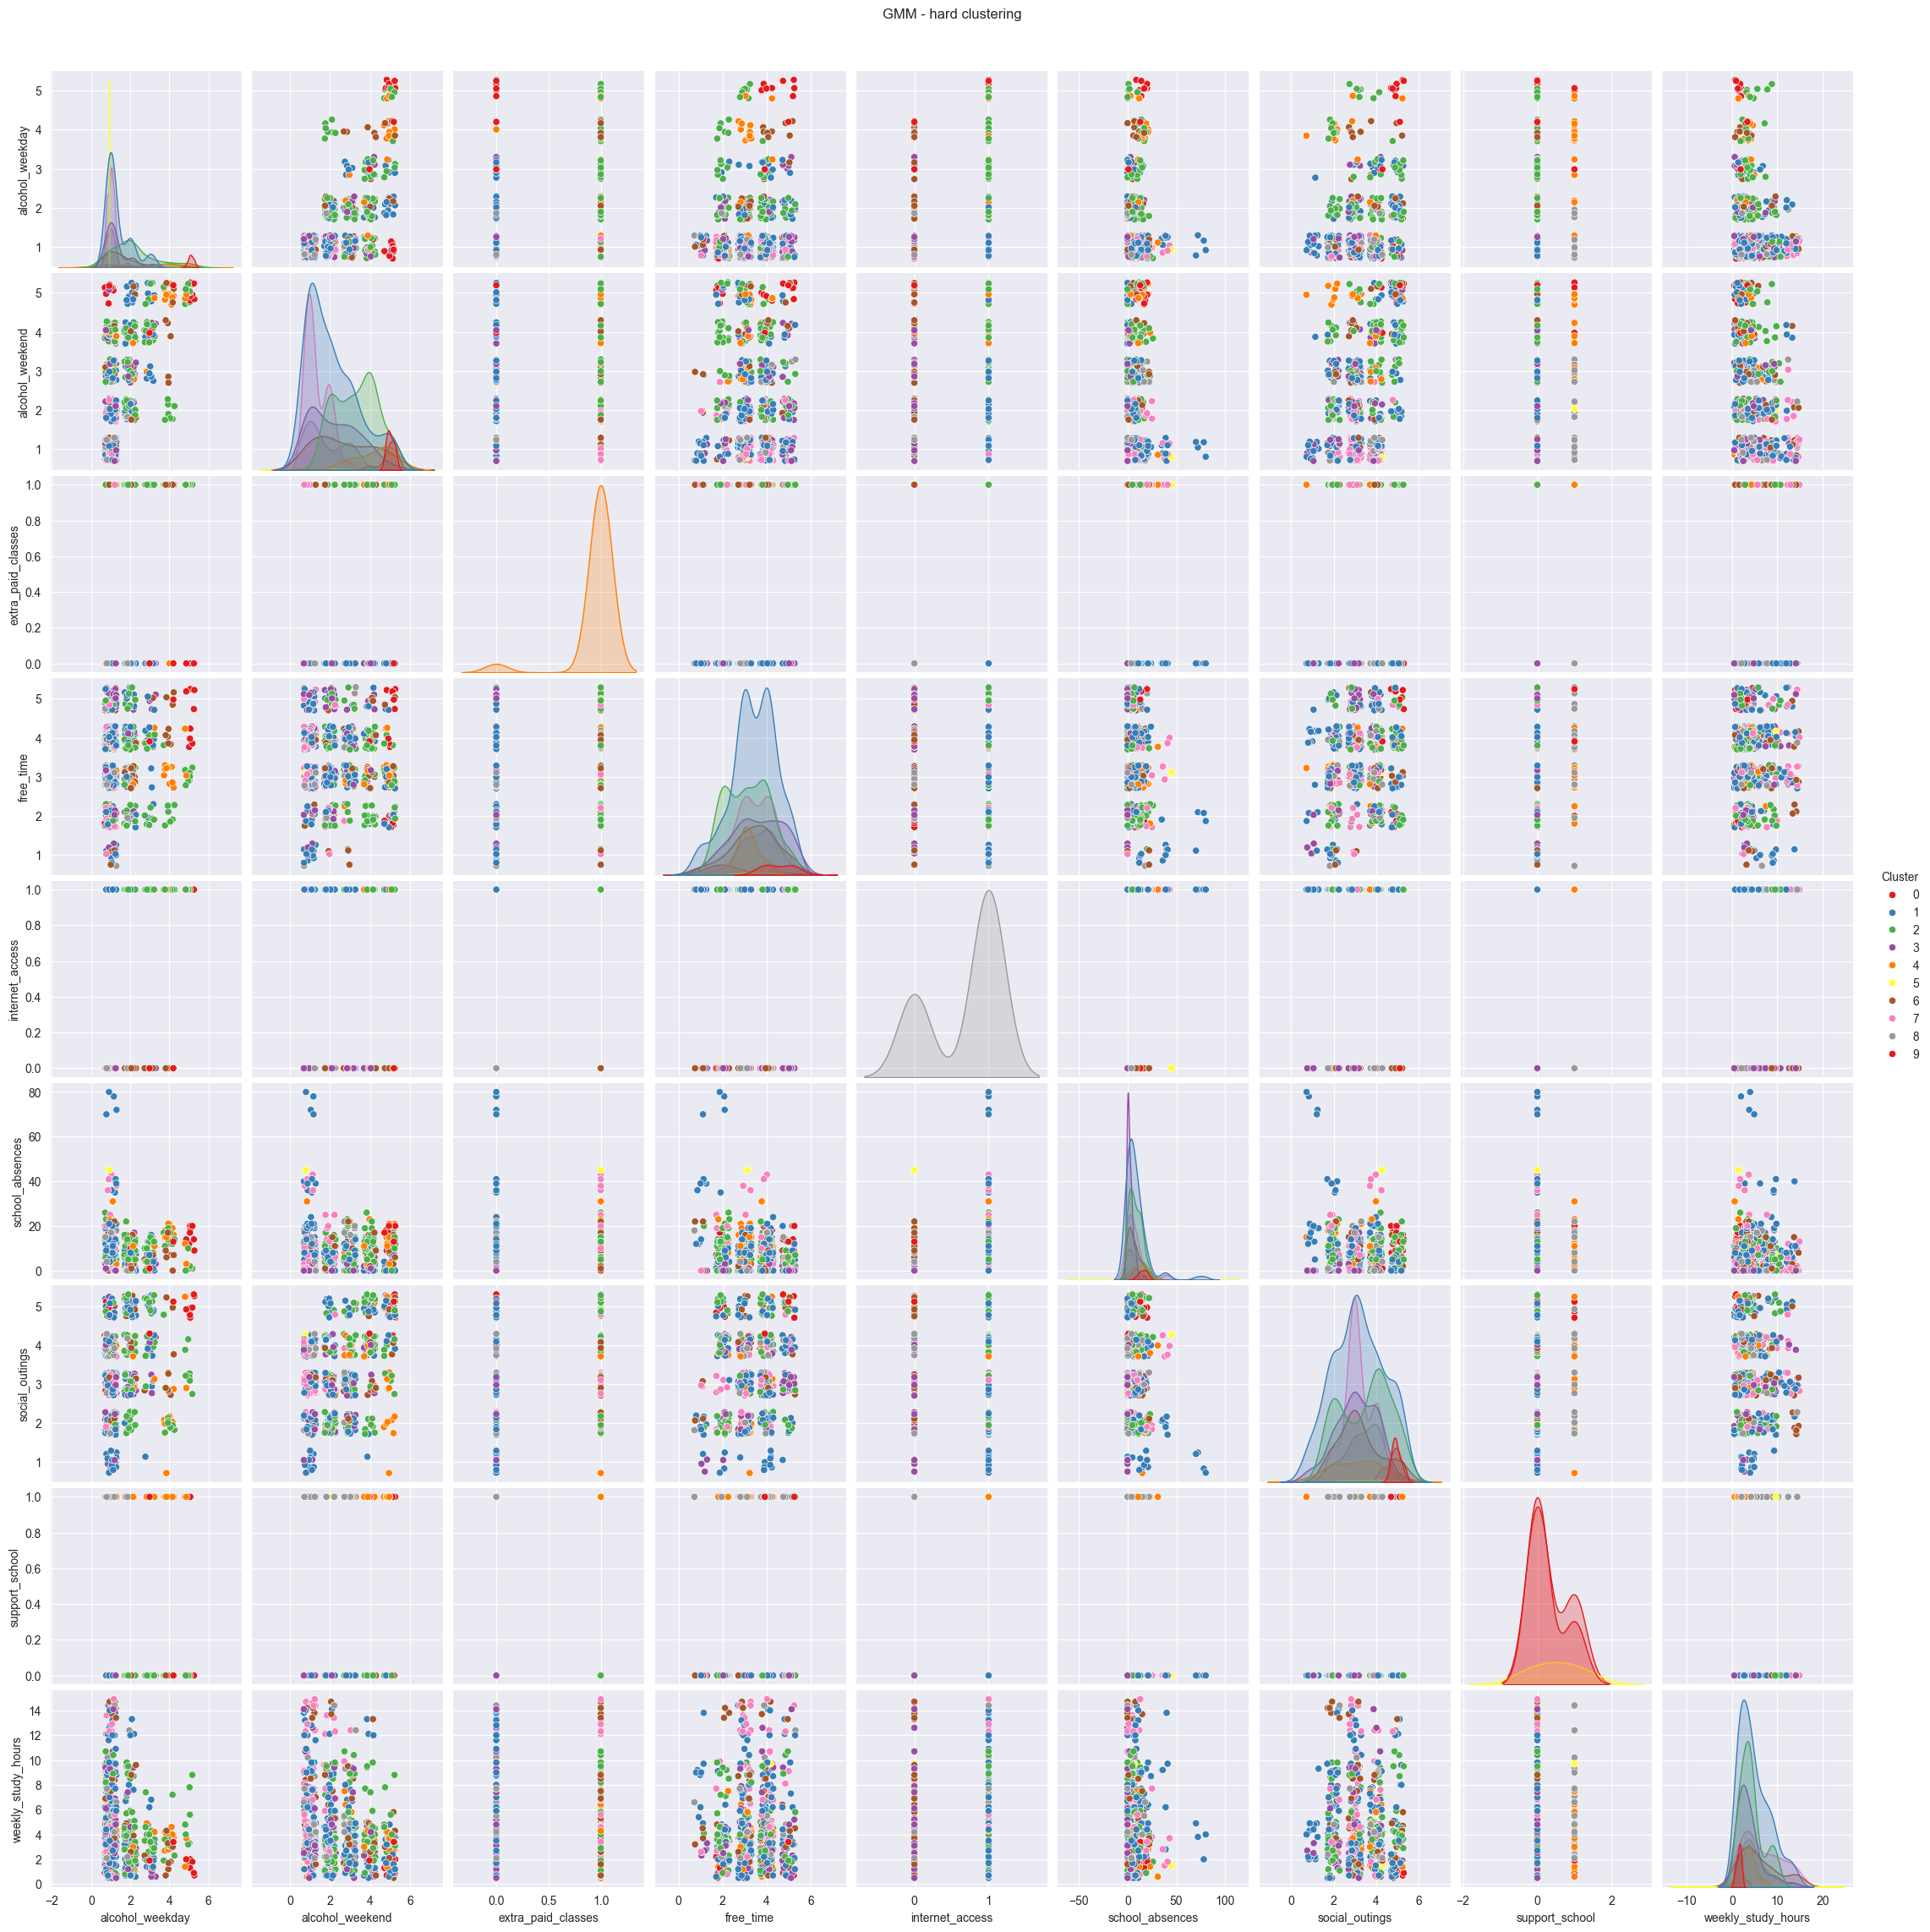

In [55]:
# pas hard clustering toe op basis van GMM
labels = best_gmm.predict(df3_scaled)

# voeg clusterlabels toe aan de data
input_data = df3.copy()
input_data.loc[:,'Cluster'] = labels

# pairplot
sns.pairplot(
    data=input_data,
    vars=['alcohol_weekday', 'alcohol_weekend', 'extra_paid_classes', 'free_time', 'internet_access',
       'school_absences', 'social_outings', 'support_school', 'weekly_study_hours'],
    hue='Cluster',
    palette="Set1",
    diag_kind="kde",
)
plt.suptitle("GMM - hard clustering", y=1.02)
plt.show()

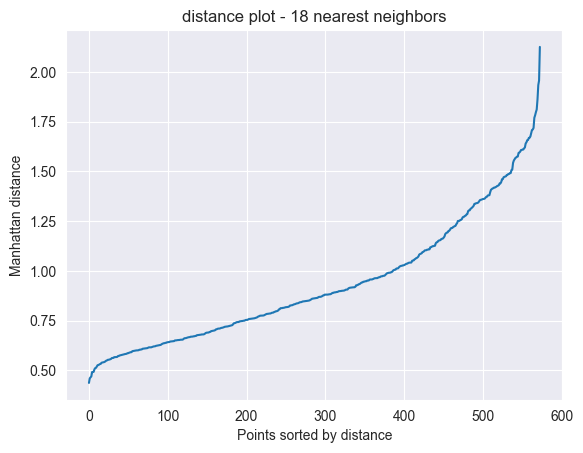

In [56]:
k = 2 * df3_scaled.shape[1]
#k = 6
neighbors = NearestNeighbors(n_neighbors=k, metric='manhattan')
neighbors_fit = neighbors.fit(df1_scaled)
distances, indices = neighbors_fit.kneighbors(df1_scaled)

# maak distance plot
distances = np.sort(distances[:, k-1])
plt.plot(distances)
plt.title(f"distance plot - {k} nearest neighbors")
plt.xlabel("Points sorted by distance")
plt.ylabel("Manhattan distance")
plt.grid(True)
plt.show()

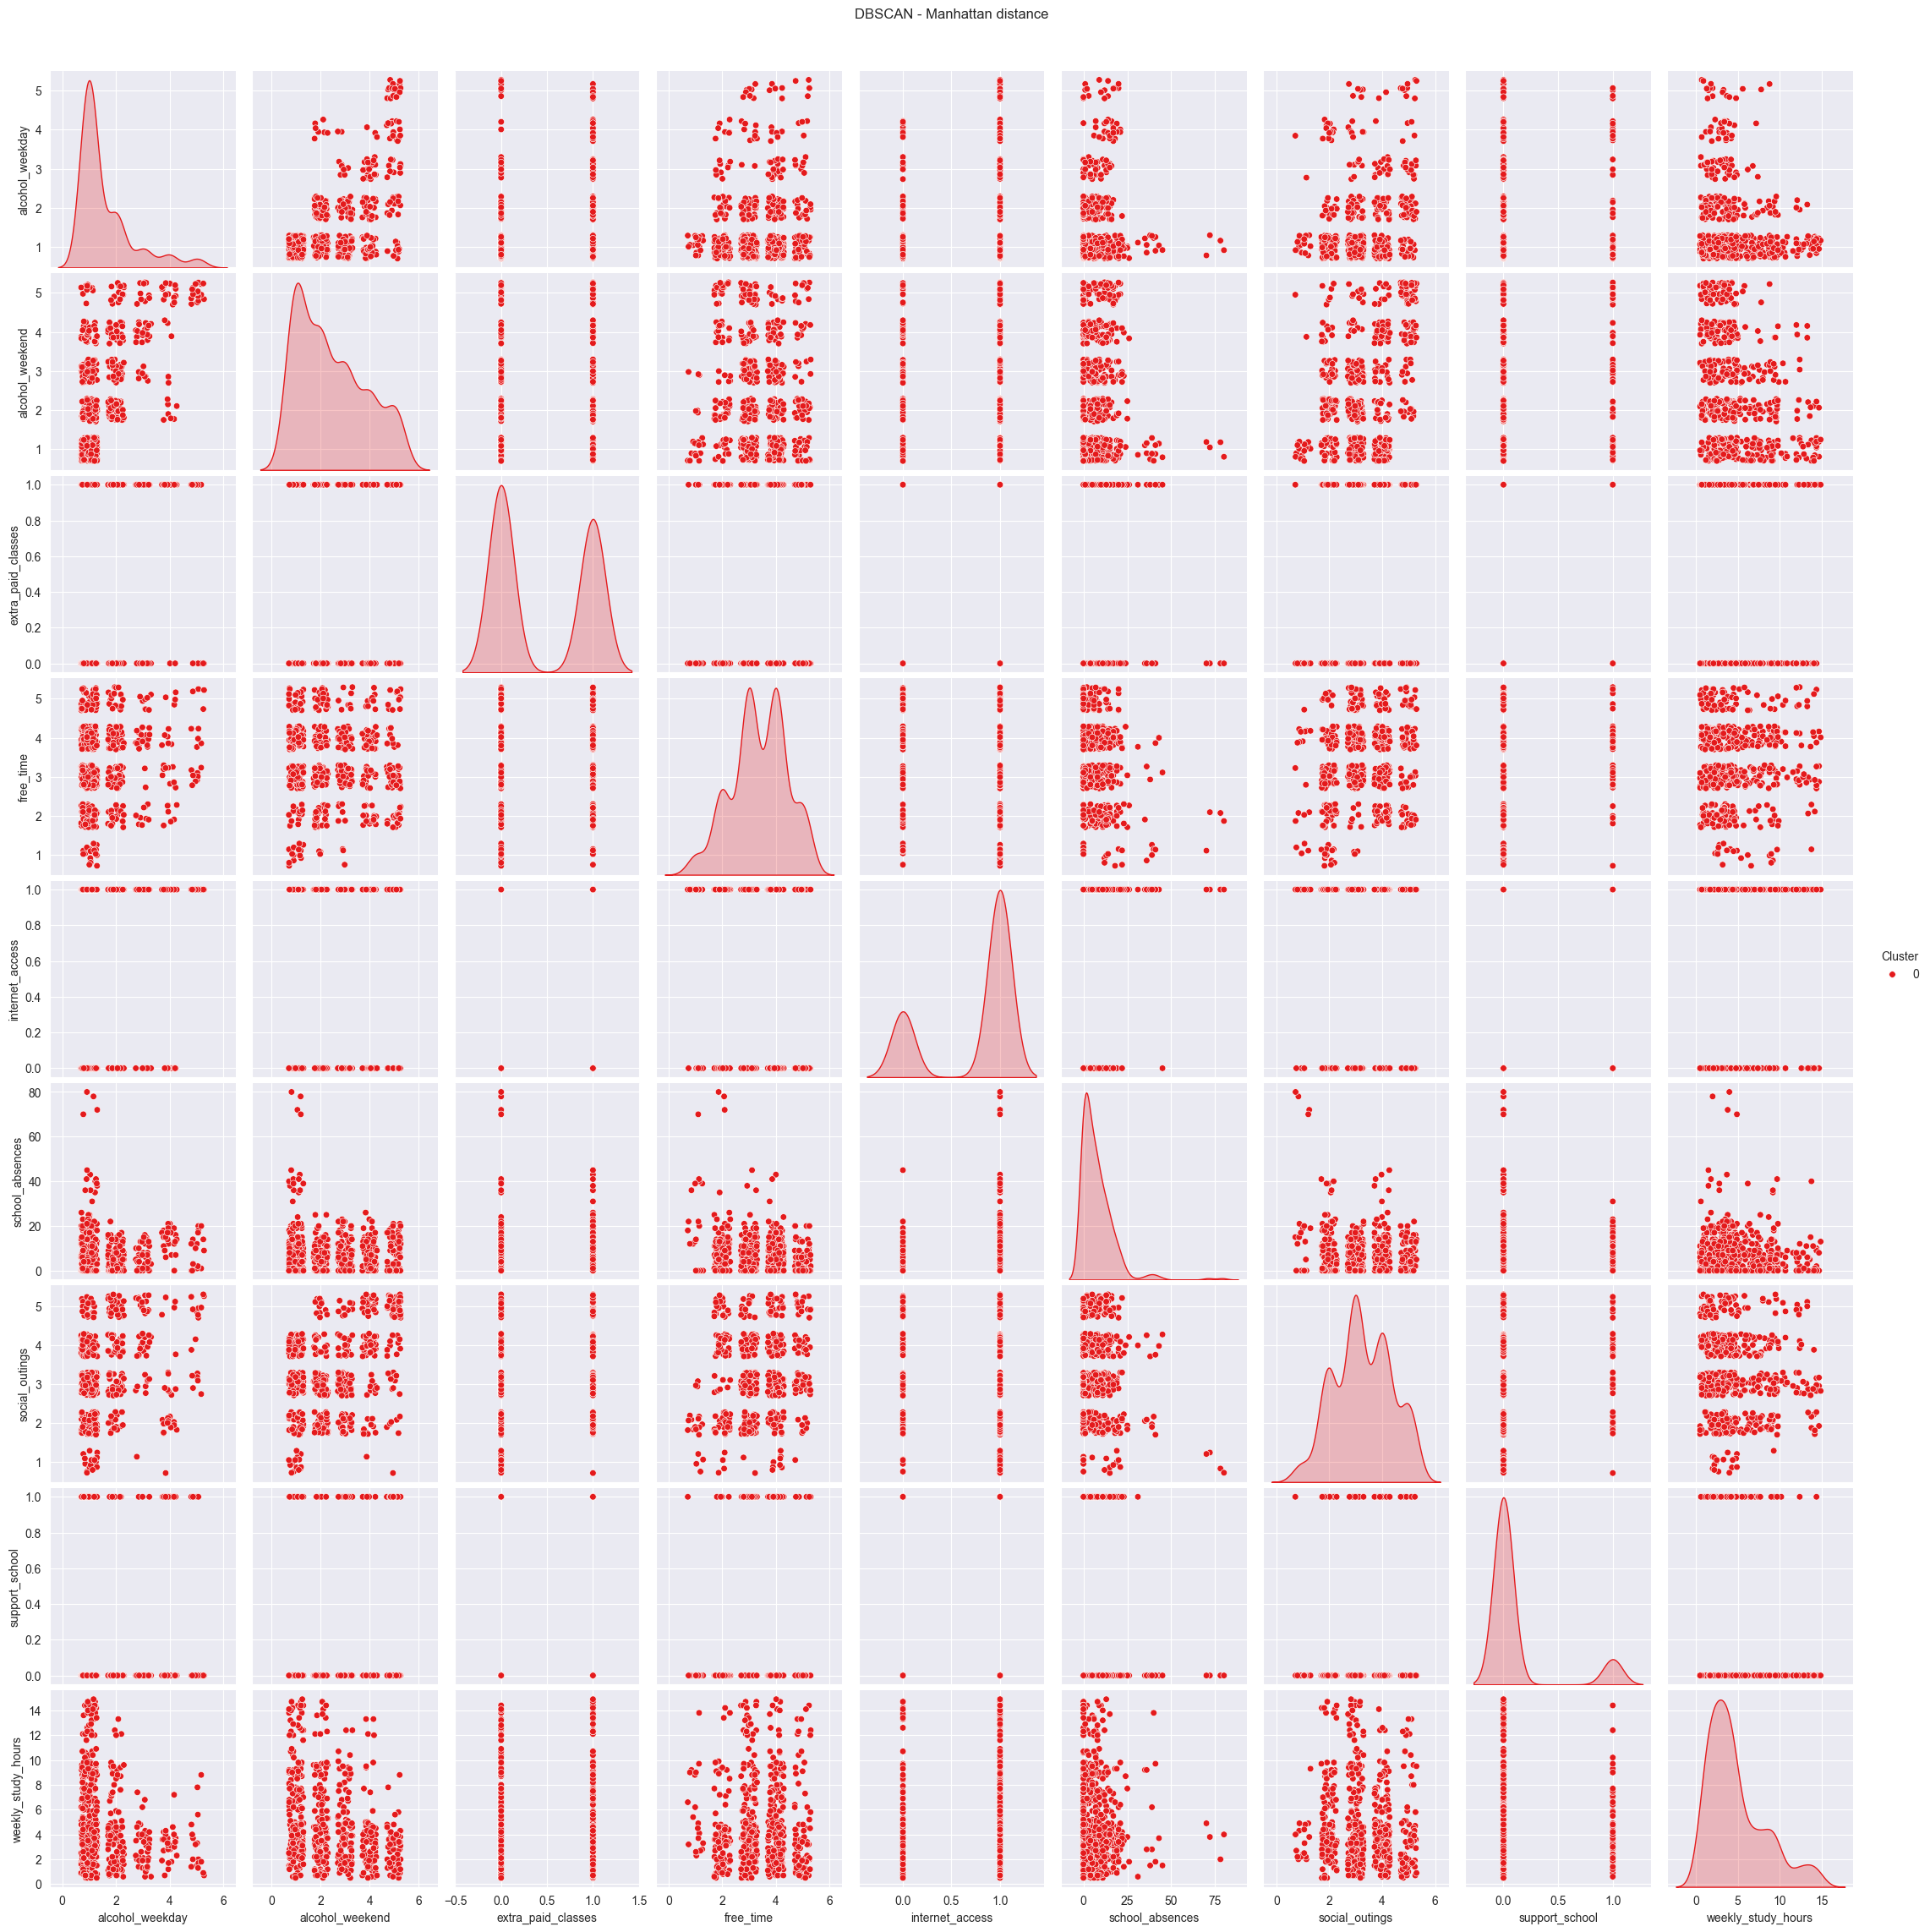

In [57]:
dbscan = DBSCAN(eps=1.5, min_samples=k, metric='manhattan')
dbscan_fit = dbscan.fit(df3_scaled)

# haal de clusterlabels en classificaties van punten op
labels = dbscan_fit.labels_

# plot clustering in pairplot
input_data = df3.copy()
input_data.loc[:,'Cluster'] = labels

sns.pairplot(input_data, hue="Cluster", palette="Set1", diag_kind="kde", plot_kws={"s": 30})
plt.suptitle("DBSCAN - Manhattan distance", y=1.02)
plt.show()

c:\Users\mitch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\mitch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



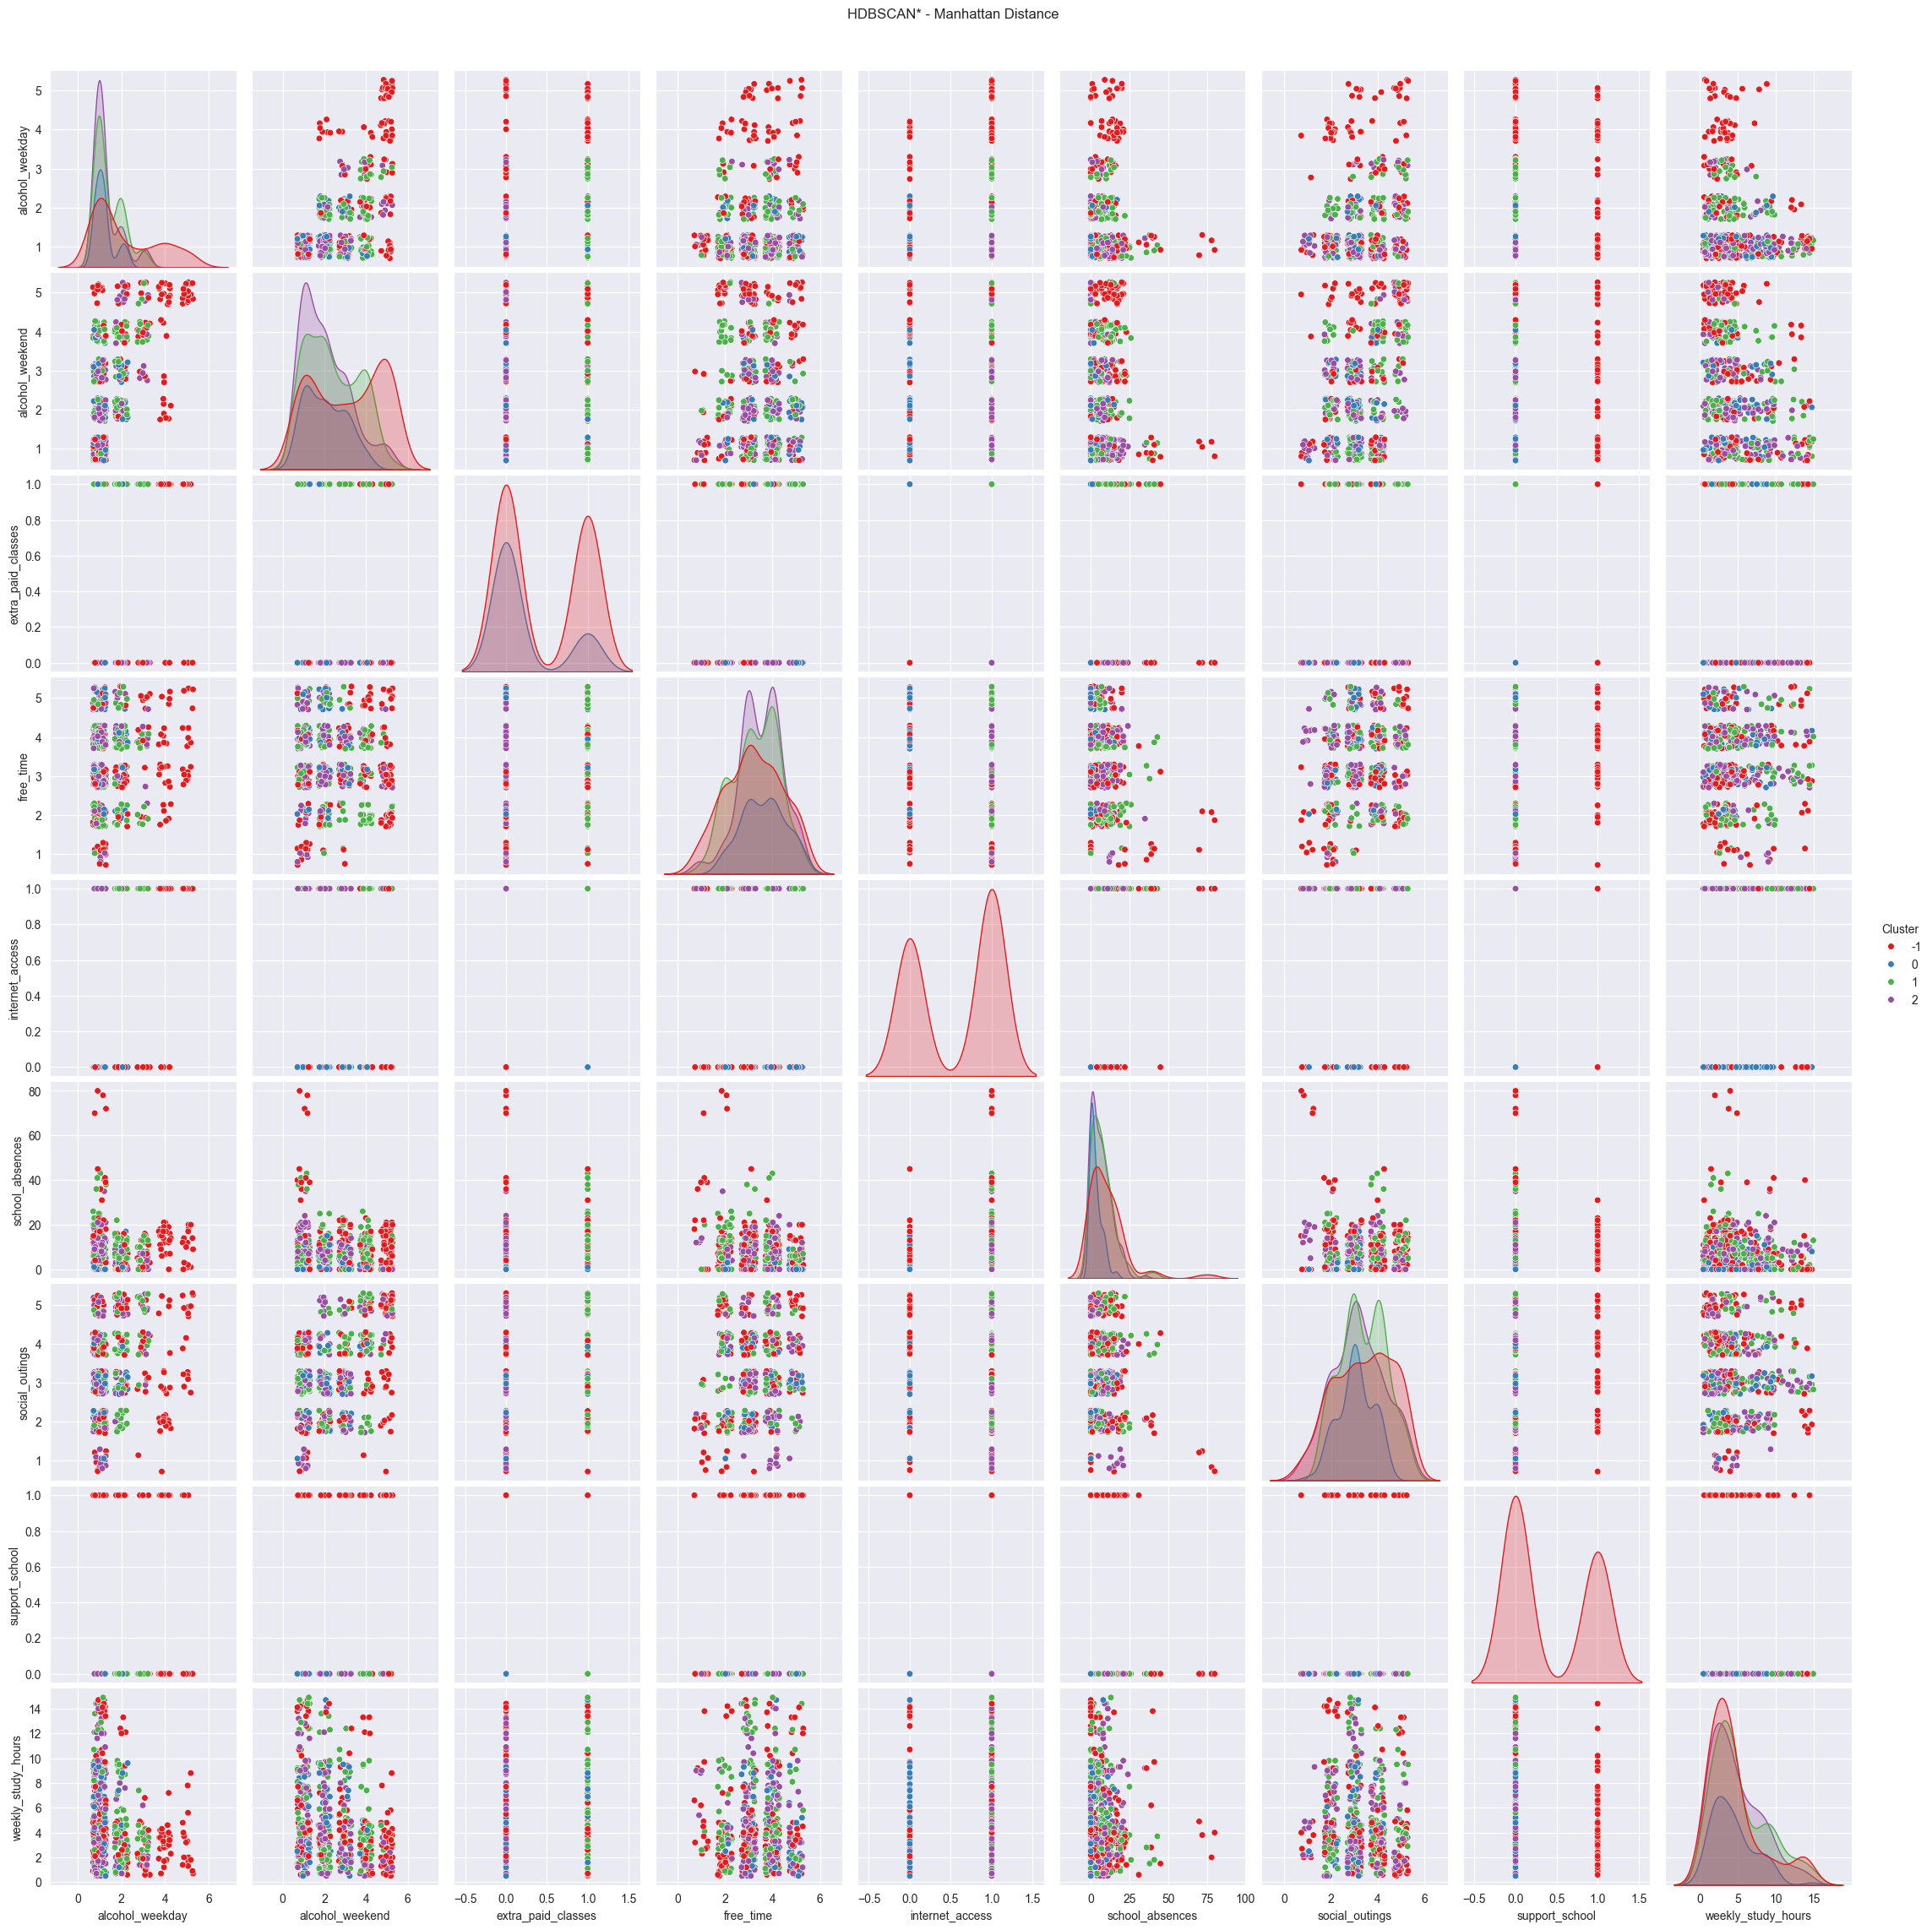

In [58]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = 2*9, metric = 'manhattan')
labels = clusterer.fit_predict(df1_scaled)

# plot clustering in pairplot
input_data = input_data.copy()
input_data.loc[:,'Cluster'] = labels

sns.pairplot(input_data, hue="Cluster", palette="Set1", diag_kind="kde", plot_kws={"s": 30})
plt.suptitle("HDBSCAN* - Manhattan Distance", y=1.02)
plt.show()

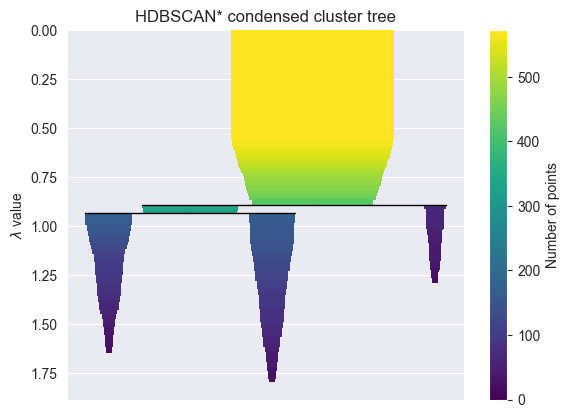

In [59]:
# plot condensed cluster tree
clusterer.condensed_tree_.plot()
plt.title("HDBSCAN* condensed cluster tree")
plt.show()

In [60]:
df_2var = df.drop(columns=bin_var)
df_2var = df_2var.drop(columns=ord_var)
scaler2 = MinMaxScaler()
scaler.fit(df_2var) # dit hebben we later nodig
df_2var_scaled = scaler.fit_transform(df_2var)

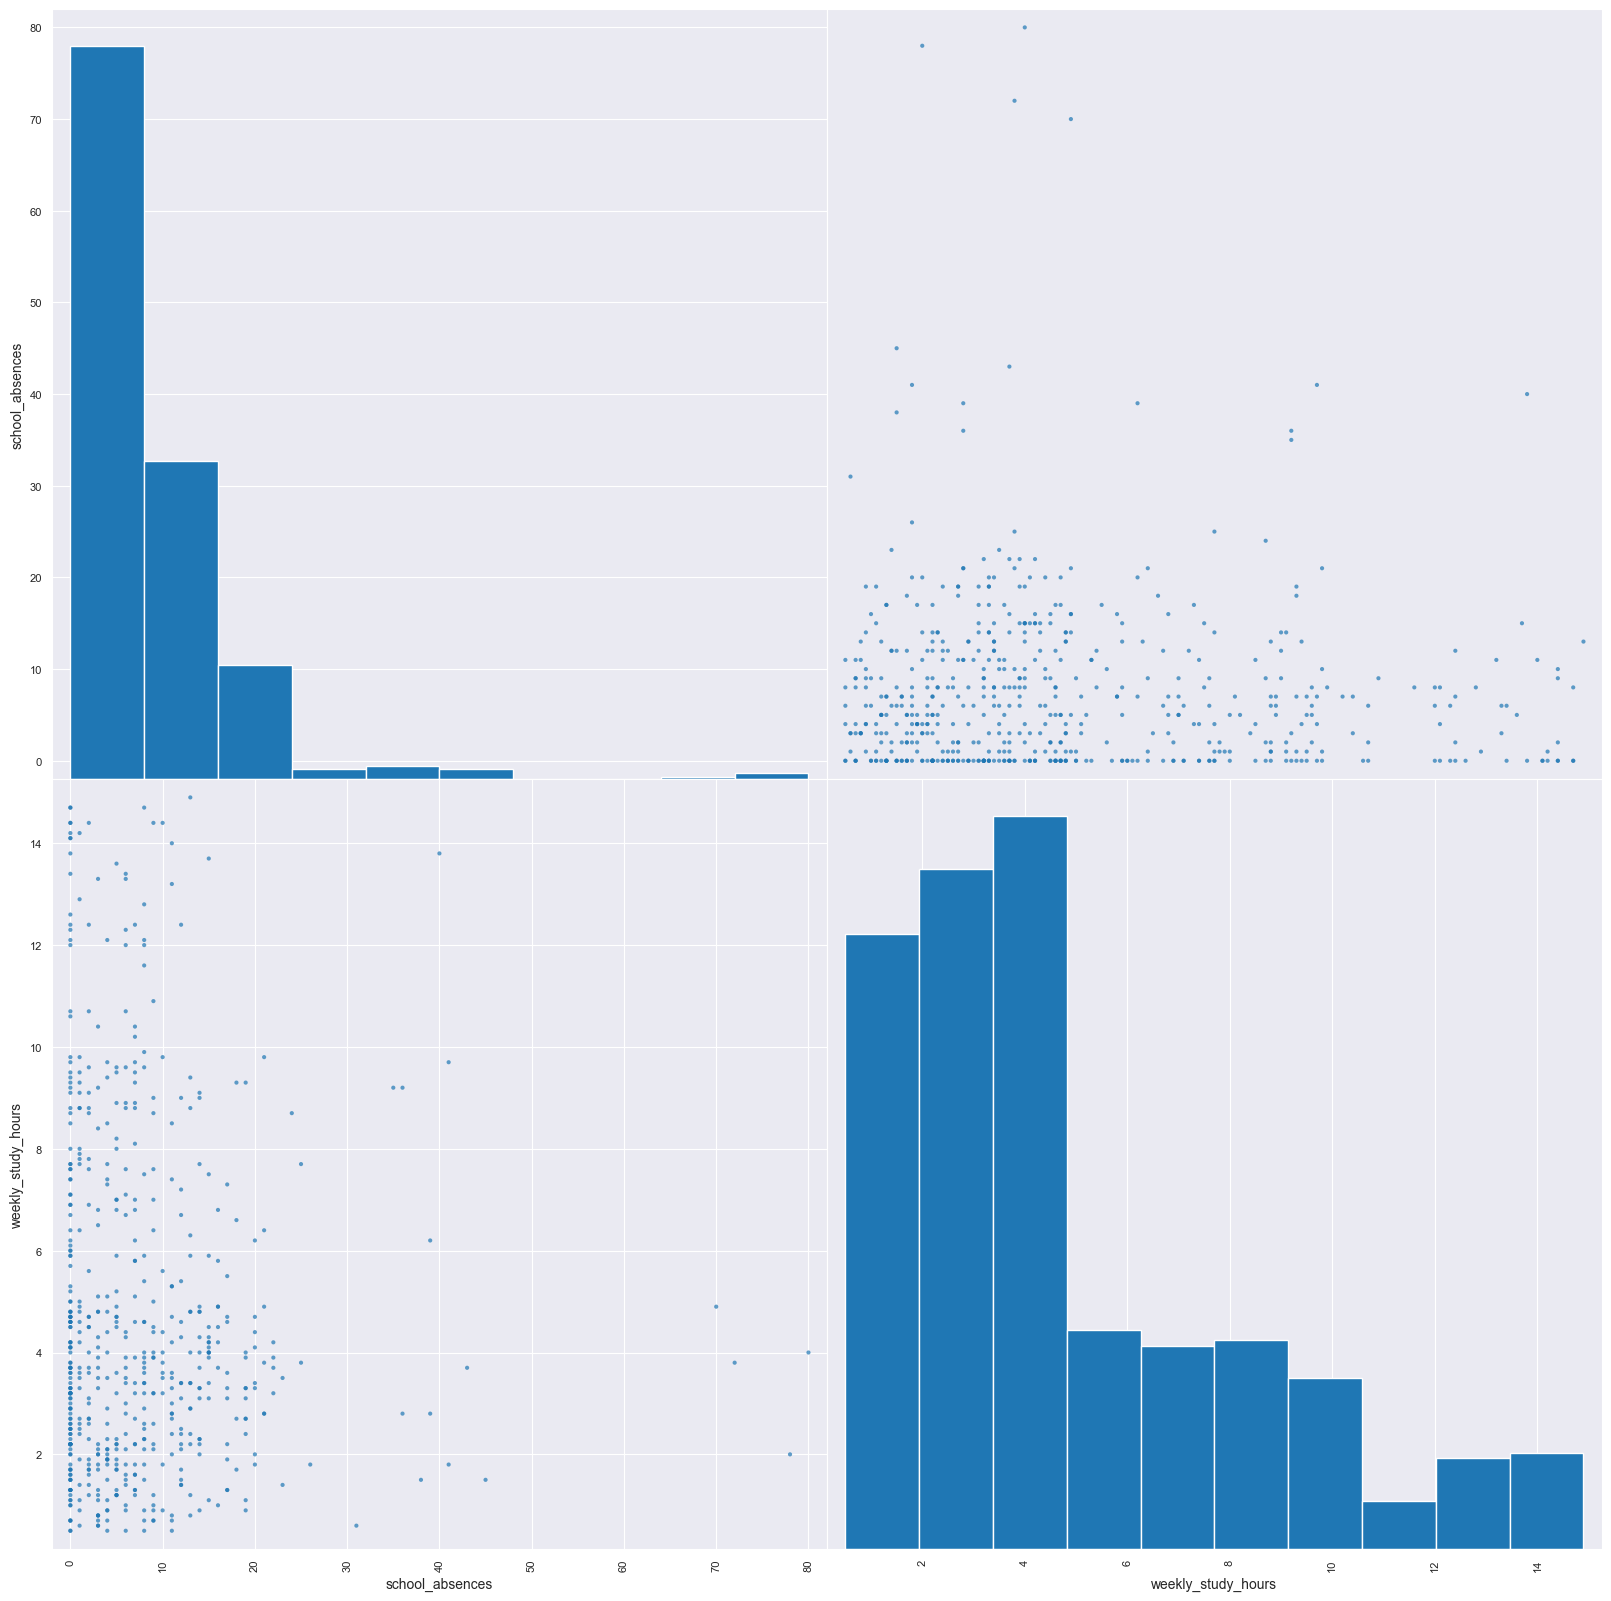

In [61]:
scatter_matrix(df_2var, figsize=(20, 20), diagonal="hist", alpha=0.7)
plt.show()

In [62]:
def objective(trial):
    n_components = trial.suggest_int("n_components", 1, 10)
    covariance_type = trial.suggest_categorical("covariance_type", ["full", "diag", "tied", "spherical"])
    reg_covar = trial.suggest_float("reg_covar", 1e-6, 1e-2, log=True)

    gmm_model = GaussianMixture(n_components=n_components, covariance_type=covariance_type, reg_covar=reg_covar)
    gmm_model.fit(df_2var_scaled)
    return gmm_model.bic(df_2var_scaled)

# maak Optuna-study met deze procedure aan
study = optuna.create_study(direction="minimize")

# voer Optuna grid search uit
optuna.logging.disable_default_handler() # optioneel: voorkom output per study
study.optimize(objective, n_trials=1000)

In [63]:
# bekijk optimalisatieproces
optuna.visualization.plot_optimization_history(study)


In [64]:
optuna.visualization.plot_slice(study)

In [65]:
best_params = study.best_params
best_params

{'n_components': 6,
 'covariance_type': 'diag',
 'reg_covar': 1.0001283858070743e-06}

In [66]:
def bootstrap_gmm_stability(X, scaler=None, n_bootstraps=100, gmm_params=None):
    n_components = gmm_params.get("n_components", 5)
    covariance_type = gmm_params.get("covariance_type", "diag")
    reg_covar = gmm_params.get("reg_covar", 1e-6)

    all_weights = []

    for i in range(n_bootstraps):
        X_resampled = resample(X, replace=True, random_state=i)

        if scaler is not None:
            X_resampled = scaler().fit_transform(X_resampled)

        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, reg_covar=reg_covar)

        gmm.fit(X_resampled)
        all_weights.append(gmm.weights_)

    return np.array(all_weights)



In [67]:
weights_matrix = bootstrap_gmm_stability(df_2var_scaled, scaler=MinMaxScaler, n_bootstraps=500, gmm_params=best_params)


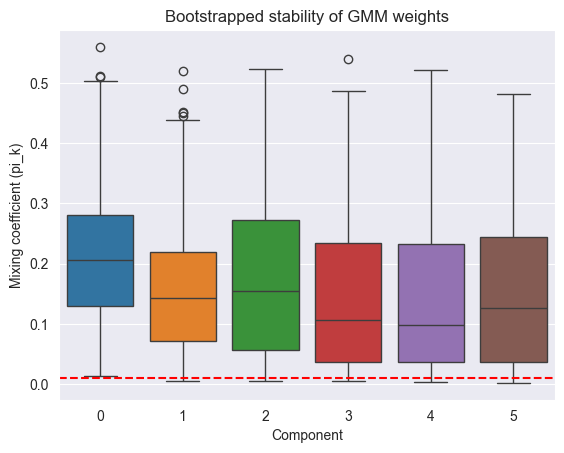

In [68]:
# visualiseer gewichten
sns.boxplot(data=weights_matrix)
plt.xlabel("Component")
plt.ylabel("Mixing coefficient (pi_k)")
plt.title("Bootstrapped stability of GMM weights")
plt.axhline(0.01, linestyle = 'dashed', color = 'red')
plt.show()


In [69]:
best_gmm = GaussianMixture(n_components=5, covariance_type=best_params['covariance_type'], reg_covar=best_params['reg_covar'])
best_gmm.fit(df_2var_scaled)


GaussianMixture(covariance_type='diag', n_components=5,
                reg_covar=1.0001283858070743e-06)

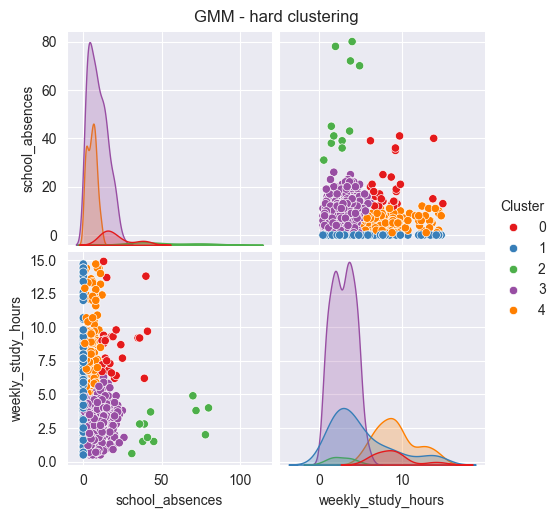

In [70]:
# pas hard clustering toe op basis van GMM
labels = best_gmm.predict(df_2var_scaled)

# voeg clusterlabels toe aan de data
input_data = df_2var.copy()
input_data.loc[:,'Cluster'] = labels

# pairplot
sns.pairplot(
    data=input_data,
    vars=['school_absences','weekly_study_hours'],
    hue='Cluster',
    palette="Set1",
    diag_kind="kde",
)
plt.suptitle("GMM - hard clustering", y=1.02)
plt.show()


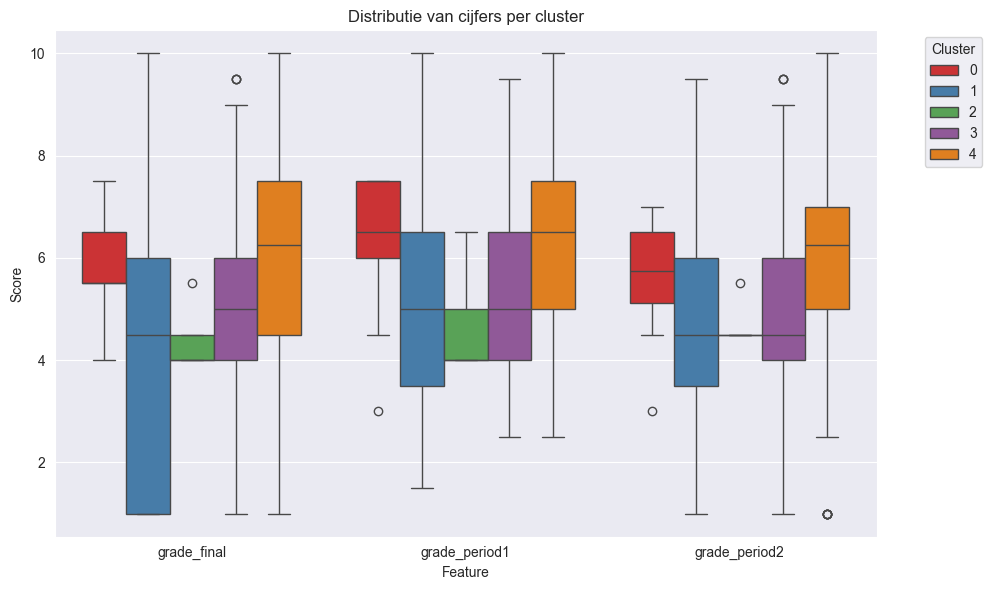

In [71]:
df_heel = df_heel.copy()
df_heel['Cluster'] = labels

# Selecteer relevante kolommen en zet ze in long-form
features = ['grade_final', 'grade_period1', 'grade_period2']
df_melted = df_heel.melt(id_vars='Cluster', value_vars=features, var_name='Feature', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Feature', y='Score', hue='Cluster', data=df_melted, palette='Set1')
plt.title('Distributie van cijfers per cluster')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\mitch\AppData\Local\Temp\ipykernel_21196\1251824396.py:54: RuntimeWarning:

invalid value encountered in divide

c:\Users\mitch\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\contour.py:1454: UserWarning:


c:\Users\mitch\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\contour.py:1455: UserWarning:


C:\Users\mitch\AppData\Local\Temp\ipykernel_21196\1251824396.py:54: RuntimeWarning:

invalid value encountered in divide

c:\Users\mitch\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\contour.py:1454: UserWarning:


c:\Users\mitch\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\contour.py:1455: UserWarning:




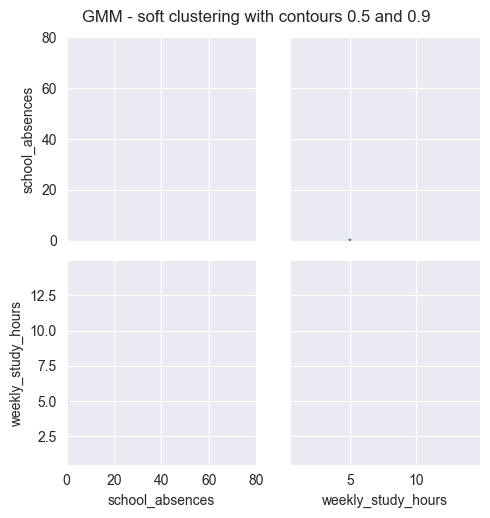

In [72]:
#bouw de pairplotmatrix voor soft clustering
features = ['school_absences', 'weekly_study_hours']
g = sns.PairGrid(df1, vars=features)

# transformeer de GMM-parameters terug naar de originele schaal
means_original = scaler.inverse_transform(best_gmm.means_)

scale = scaler.scale_
covariances_original = []
for diag_var in best_gmm.covariances_:
    if diag_var.ndim == 1:
        # diag_var bevat varianties per feature in geschaalde ruimte
        original_variances = diag_var * (scale ** 2)
        cov_matrix = np.diag(original_variances)
    else:
        # voor 'full' covariance_type
        cov_matrix = diag_var * scale[:, None] * scale[None, :]
    covariances_original.append(cov_matrix)
#scale = scaler.data_range_  
#covariances_original = [
#    np.diag(diag_var * scale**2) if diag_var.ndim == 1 else diag_var * scale**2
#    for diag_var in best_gmm.covariances_
#]

# functie voor plotten contours (soft clustering)
def plot_gmm_contours(x, y, levels=[0.5, 0.9], **kwargs):
    ax = plt.gca()
    palette = sns.color_palette("Set1", best_gmm.n_components)

    # plot niets op de diagonaal (voegt niets toe)
    if x.name == y.name:
        return

    xi = features.index(x.name)
    yi = features.index(y.name)

    for i in range(best_gmm.n_components):
        mean = means_original[i][[xi, yi]]
        cov = covariances_original[i][np.ix_([xi, yi], [xi, yi])]
        eigvals = np.linalg.eigvalsh(cov)

        # maak het grid
        x_range = input_data[x.name]
        y_range = input_data[y.name]
        xx, yy = np.meshgrid(
            np.linspace(x_range.min(), x_range.max(), 100),
            np.linspace(y_range.min(), y_range.max(), 100)
        )
        pos = np.dstack((xx, yy))
        rv = multivariate_normal(mean, cov)
        z = rv.pdf(pos)

        # normaliseer
        z /= z.max()

        # plot gewenste contouren
        for level in levels:
            linestyle = 'dashed' if level < 0.7 else 'solid'
            ax.contour(xx, yy, z, levels=[level], colors=[palette[i]], linestyles=linestyle)

# maak de plot
g.map(plot_gmm_contours, levels = [0.5, 0.9])
g.map_diag(lambda *args, **kwargs: None)
plt.suptitle("GMM - soft clustering with contours 0.5 and 0.9", y=1.02)

# geef de plot weer
plt.show()

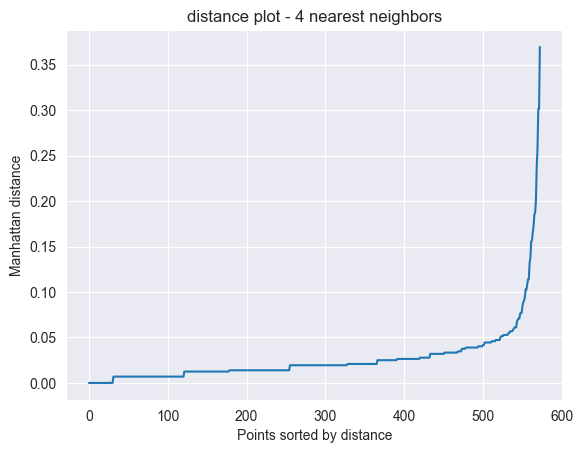

In [73]:
k = 2 * df_2var_scaled.shape[1]
neighbors = NearestNeighbors(n_neighbors=k, metric='manhattan')
neighbors_fit = neighbors.fit(df_2var_scaled)
distances, indices = neighbors_fit.kneighbors(df_2var_scaled)

# maak distance plot
distances = np.sort(distances[:, k-1])
plt.plot(distances)
plt.title(f"distance plot - {k} nearest neighbors")
plt.xlabel("Points sorted by distance")
plt.ylabel("Manhattan distance")
plt.grid(True)
plt.show()

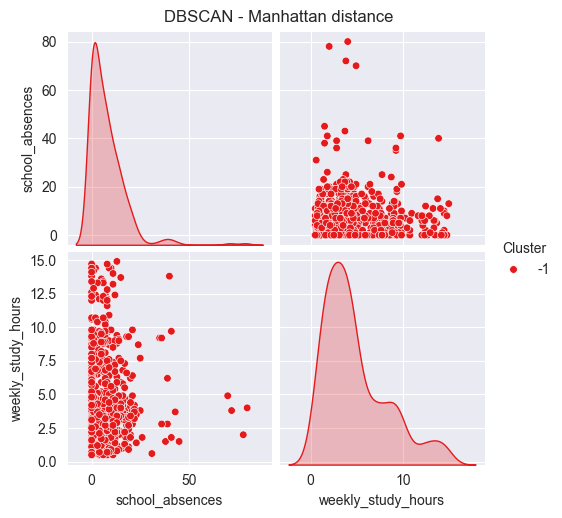

In [74]:
# voer DBSCAN uit
dbscan = DBSCAN(eps=0.05, min_samples=k, metric='manhattan')
dbscan_fit = dbscan.fit(df1_scaled)

# haal de clusterlabels en classificaties van punten op
labels = dbscan_fit.labels_

# plot clustering in pairplot
input_data = df_2var.copy()
input_data.loc[:,'Cluster'] = labels

sns.pairplot(input_data, hue="Cluster", palette="Set1", diag_kind="kde", plot_kws={"s": 30})
plt.suptitle("DBSCAN - Manhattan distance", y=1.02)
plt.show()

c:\Users\mitch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\mitch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



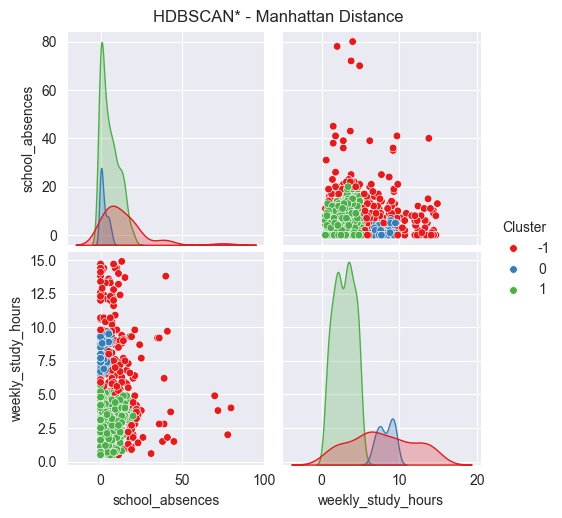

In [75]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = 2*7, metric = 'manhattan')
labels = clusterer.fit_predict(df_2var_scaled)

# plot clustering in pairplot
input_data = input_data.copy()
input_data.loc[:,'Cluster'] = labels

sns.pairplot(input_data, hue="Cluster", palette="Set1", diag_kind="kde", plot_kws={"s": 30})
plt.suptitle("HDBSCAN* - Manhattan Distance", y=1.02)
plt.show()

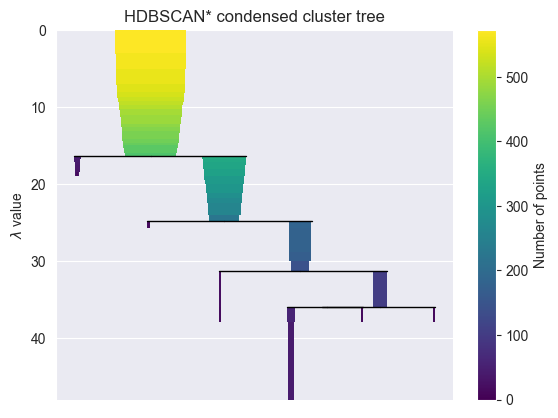

In [76]:
# plot condensed cluster tree
clusterer.condensed_tree_.plot()
plt.title("HDBSCAN* condensed cluster tree")
plt.show()

In [77]:
df_heel = df_heel.copy()
df_heel['Cluster'] = labels

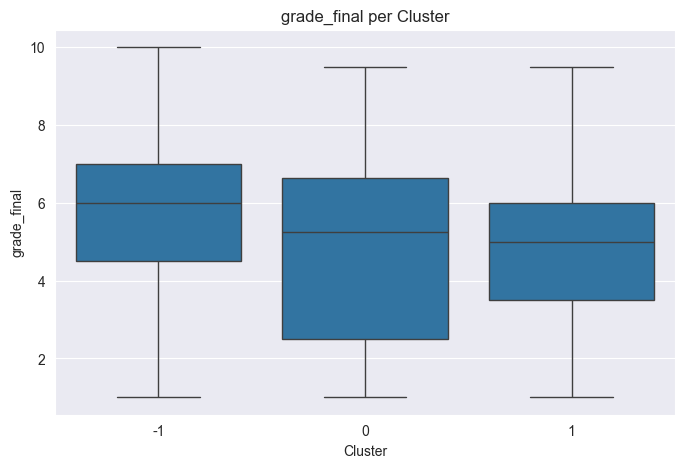

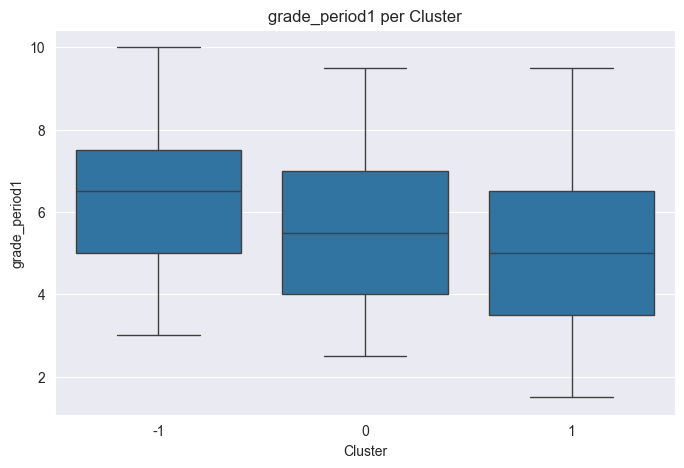

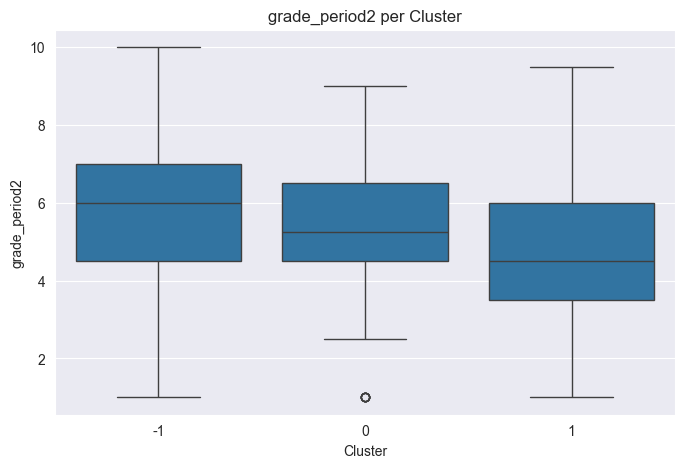

In [78]:
features = ['grade_final', 'grade_period1', 'grade_period2']

for feature in features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Cluster', y=feature, data=df_heel)
    plt.title(f'{feature} per Cluster')
    plt.show()

In [79]:
df_heel.groupby('Cluster')[features].mean()

grade_final  grade_period1  grade_period2
Cluster                                           
-1          5.859756       6.195122       5.826220
 0          4.955357       5.687500       5.258929
 1          4.475921       5.062323       4.705382

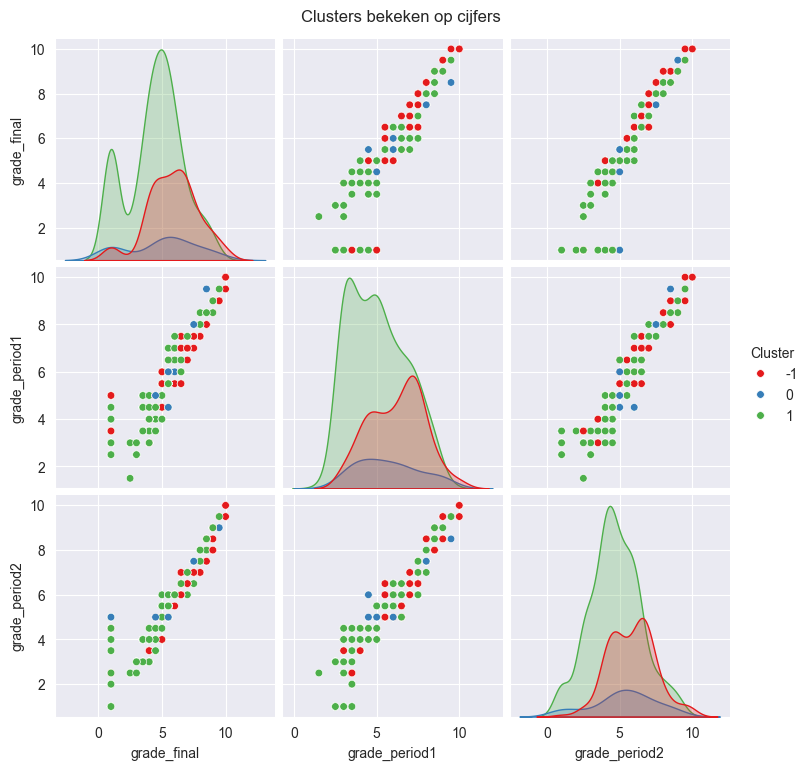

In [80]:
sns.pairplot(df_heel[features + ['Cluster']], hue='Cluster', palette='Set1', diag_kind='kde', plot_kws={"s": 30})
plt.suptitle("Clusters bekeken op cijfers", y=1.02)
plt.show()

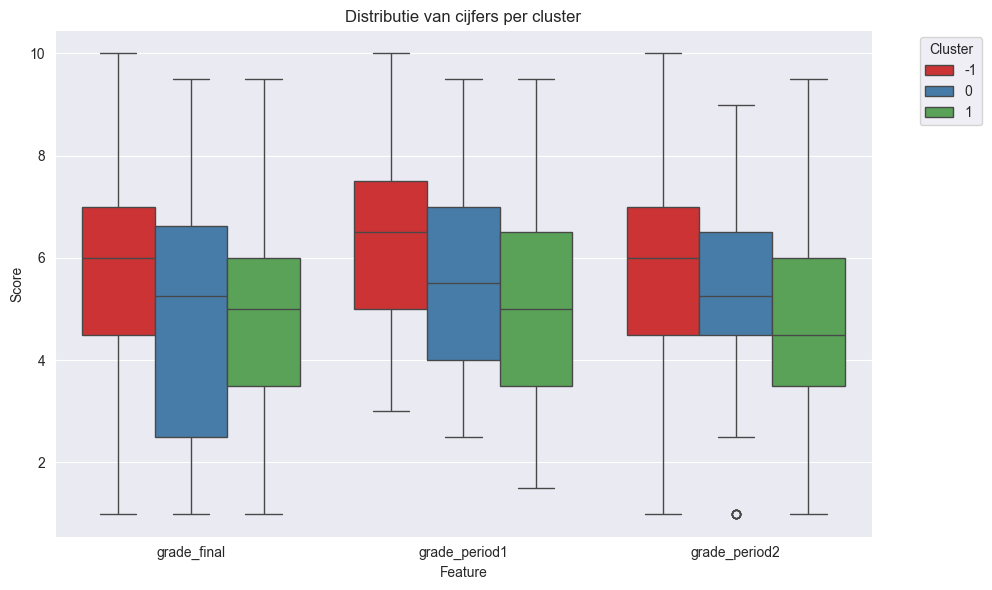

In [81]:
df_heel = df_heel.copy()
df_heel['Cluster'] = labels

# Selecteer relevante kolommen en zet ze in long-form
features = ['grade_final', 'grade_period1', 'grade_period2']
df_melted = df_heel.melt(id_vars='Cluster', value_vars=features, var_name='Feature', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Feature', y='Score', hue='Cluster', data=df_melted, palette='Set1')
plt.title('Distributie van cijfers per cluster')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()